In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

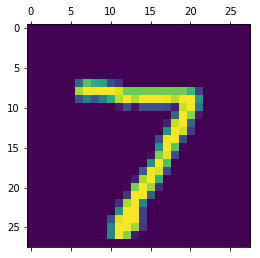

In [2]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

In [3]:
batch_size = 16
data_size = len(train_data[0])
n_epochs = 5000
learning_rate = .001
n_labels = 10

In [4]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

In [5]:
input_data = tf.placeholder(tf.float32,shape = (None,data_size))
labels = tf.placeholder(tf.float32,shape = (None,10))

In [6]:
layer1 = tf.layers.dense(input_data,256,activation = tf.nn.relu)
layer2 = tf.layers.dense(layer1,256,activation = tf.nn.relu)
layer3 = tf.layers.dense(layer2,256,activation = tf.nn.relu)

logits = tf.layers.dense(layer2,n_labels,activation = None)

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits))
adam = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = adam.minimize(loss)

In [8]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

In [9]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

In [10]:
results = []
print_freq = 500
test_freq = 10
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss,train_logits = sess.run([train,loss,logits],{input_data:batch_data,labels:batch_labels})
    
    if k%test_freq == 0:
        test_loss,test_logits = sess.run([loss,logits],{input_data:normed_test,labels:test_label_1h})
        results.append([k,MNIST_err(test_label_1h,test_logits),MNIST_err(batch_labels,train_logits)])
    if k%print_freq == 0:
        print("{}\t{}\t{}".format(k,train_loss,test_loss))
        
results = np.array(results)

0	2.456284523010254	2.404623508453369
500	0.47951772809028625	0.223442941904068
1000	0.020957253873348236	0.19495441019535065
1500	0.029129914939403534	0.24114638566970825
2000	0.2002839744091034	0.189726784825325
2500	0.07177537679672241	0.18938611447811127
3000	0.012079345993697643	0.19243496656417847
3500	0.11272497475147247	0.1949847936630249
4000	0.0008231680258177221	0.20714963972568512
4500	0.0010586949065327644	0.21931889653205872


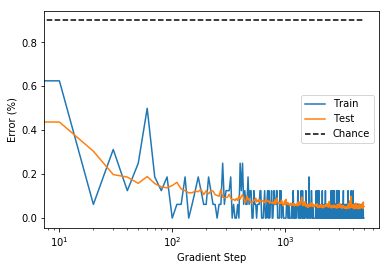

In [11]:
plt.plot(results[:,0],1-results[:,2],label = "Train")
plt.plot(results[:,0],1-results[:,1],label = "Test")
plt.plot(results[:,0],np.ones_like(results[:,1])*.9,"k--",label = "Chance")
plt.legend()
plt.xlabel("Gradient Step")
plt.ylabel("Error (%)")
plt.xscale("log")
plt.show()